In [1]:

from monai.transforms import (Compose)
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import Compose, Invertd, SaveImaged
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
import torch
import json


In [3]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
ga_output_dir = config["ga_output_dir"]
artifact_dir = config["artifacts"]
artifact_output = config ["artifact_output"]
fdg_output_dir = config['fdg_output_dir']


In [4]:
from data_preparation import DataHandling 

data_handler = DataHandling(ga_data_dir, train_mode="NAC", target_mode="MAC")

train_files = data_handler.get_data_split('train')
val_files = data_handler.get_data_split('val')
test_files = data_handler.get_data_split('test')
print(len(train_files))
print(len(val_files))
print(len(test_files))

from data_preparation import LoaderFactory
loader_factory = LoaderFactory(
    train_files=train_files,
    val_files=val_files,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    # spacing = [1.92, 1.92, 3.27], # For fdg data
    spatial_size = (168, 168, 400)
    # spatial_size = (336, 336, 640) # for Fdg data
    )

test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)



129
33
20


In [3]:
# from data_preparation import ExternalRadioSetHandling

# data_handler = ExternalRadioSetHandling(data_dir=fdg_data_dir, test_ratio=0.2)
# train_files, val_files, test_files = data_handler.get_split_data()

# print(f"Test data length: {len(test_files)}")
# print(f"Validation data length: {len(val_files)}")
# print(f"Train data length: {len(train_files)}")

Test data length: 21
Validation data length: 15
Train data length: 62


In [4]:
# from data_preparation import ExtrenalRadioSetSetHandling

# data_handler = ExtrenalRadioSetSetHandling(fdg_data_dir, train_mode="NAC", target_mode="MAC")

# test_files = data_handler.get_data()
# print(len(test_files))

# from data_preparation import LoaderFactory
# loader_factory = LoaderFactory(
#     train_files=None,
#     val_files=None,
#     test_files=test_files,
#     patch_size = [168, 168, 16],
#     spacing = [4.07, 4.07, 3.00],
#     # spacing = [1.92, 1.92, 3.27], # For fdg data
#     # spatial_size = (168, 168, 400)
#     # spatial_size = (336, 336, 640)
#     spatial_size = (168, 168, 600) # for Fdg data
#     )

# test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)



98


In [ ]:
# from data_preparation import ExtrenalRadioSetSetHandling

# data_handler = ExtrenalRadioSetSetHandling(artifact_dir, train_mode="NAC", target_mode="MAC")

# test_files = data_handler.get_data()
# print(len(test_files))

# from data_preparation import LoaderFactory
# loader_factory = LoaderFactory(
#     # train_files=train_files,
#     # val_files=val_files,
#     test_files=test_files,
#     patch_size = [168, 168, 16],
#     spacing = [4.07, 4.07, 3.00],
#     spatial_size = (168, 168, 480)
#     )

# # Get the DataLoader for each dataset type
# # train_loader = loader_factory.get_loader('train', batch_size=4, num_workers=2, shuffle=True)
# # val_loader = loader_factory.get_loader('val', batch_size=1, num_workers=2, shuffle=False)
# test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)


In [ ]:
# from monai.transforms import LoadImage

# # Assuming 'test_files' contains your image paths like {'image': 'path/to/image.nii', 'target': 'path/to/target.nii'}
# loader = LoadImage(image_only=True)

# for i in test_files:
#     image_path = i['image']  # Replace 'test_files[0]['image']' with the actual path if necessary
#     original_image = loader(image_path)
#     print(f"Original image size: {original_image.shape}")

# print('--------------------------')
# for batch in test_loader:
#     transformed_image = batch['image']
#     print(f"Transformed image size: {transformed_image.shape}")
#       # Break after the first batch since you're only interested in one image


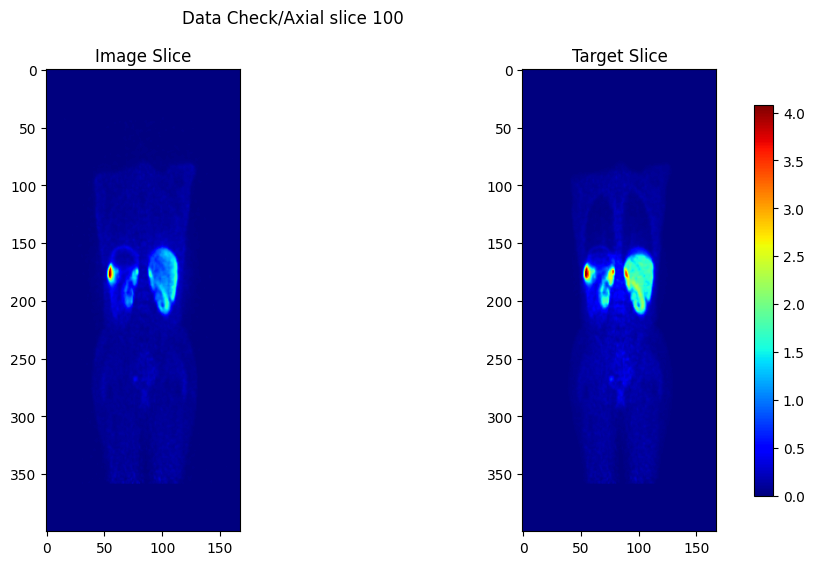

In [5]:
from data_preparation import visualize_axial_slice, visualize_axial_slice2


slice_index = 100  # Example slice index.
visualize_axial_slice2(test_loader, slice_index)


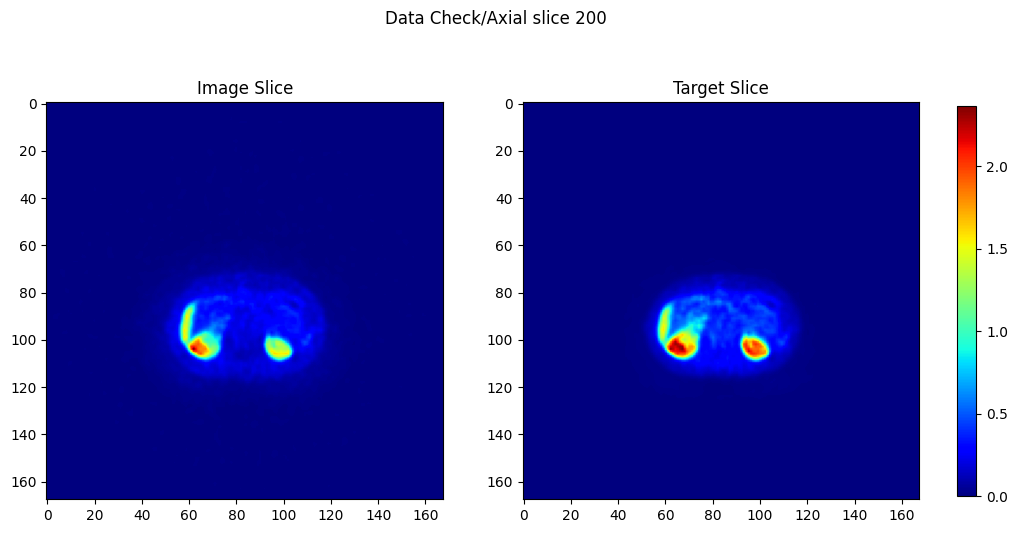

In [6]:
slice_index = 200  # Example slice index.
visualize_axial_slice(test_loader, slice_index)



In [19]:
from utils import find_last_saved_model, parse_loss_values

# log_filename = 'log_2_26_8_17.txt' # saved on hard
# log_filename = 'log_3_4_12_4.txt' # saved on hard
# log_filename = 'log_3_4_12_41.txt' # saved on hard
log_filename = 'log_3_18.txt'
log_filename = 'log_3_27_8_47.txt'
# log_filename = 'log_3_28_6_8.txt'
# log_filename = 'log_3_28_10_41.txt'
# log_filename = 'log_3_28_20_48.txt'
# log_filename = 'log_3_29_6_54.txt'
# log_filename = 'log_4_6_8_55.txt'
log_filename = 'log_4_17_16_3.txt'
log_filename = 'log_4_17_19_29.txt' # Ga, new structure.
log_filename = 'log_4_23_21_47.txt' # Edameye log_4_17_19_29


log_filepath = log_dir + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_4_24_23_17.pth, Best Metric: 0.0527, Epoch: 78


In [ ]:
# bestmodel_filename =  'model_4_2_0_41.pth'

# best_metric = 0.3338
# best_epoch = 38

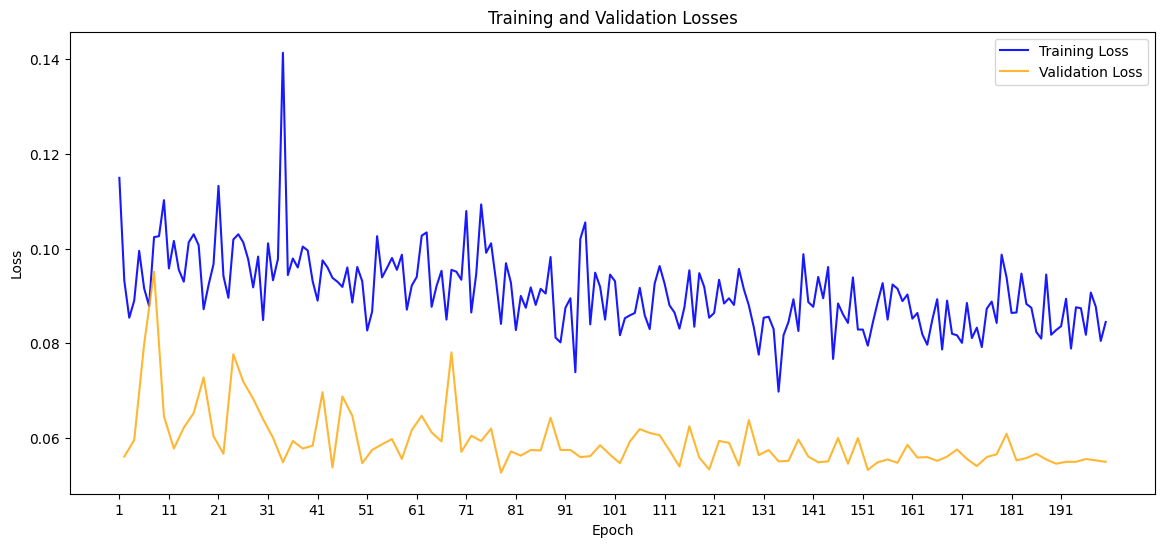

In [20]:
train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 10))  # Adjust the x-axis ticks if needed
plt.show()


In [11]:
import os
import torch
from model_maker import get_network, add_activation_before_output
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_network(patch_size = [168, 168, 16], spacing = [4.07, 4.07, 3.00])

model = model.to(device)

add_activation_before_output(model, nn.ReLU(inplace=True))
model

DyUnet is set:
Kernel size:  [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides:  [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 1]]


DynUNet(
  (input_block): UnetBasicBlock(
    (conv1): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (conv2): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (norm2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (downsamples): ModuleList(
    (0): UnetBasicBlock(
      (conv1): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
      (norm1): InstanceNorm3d(64, eps=1e-05

In [21]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(log_dir, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_4_24_23_17.pth is loading.


In [13]:
# Extract file names
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]
test_name


[('007026_C5_RJ_.nii', '007026_C5_RJ_.nii'),
 ('007035_C5_RJ_.nii', '007035_C5_RJ_.nii'),
 ('007037_C5_RJ_.nii', '007037_C5_RJ_.nii'),
 ('007038_C5_RJ_.nii', '007038_C5_RJ_.nii'),
 ('007042_C5_RJ_.nii', '007042_C5_RJ_.nii'),
 ('007043_C5_RJ_.nii', '007043_C5_RJ_.nii'),
 ('007046_C5_RJ_.nii', '007046_C5_RJ_.nii'),
 ('007051_C5_RJ_.nii', '007051_C5_RJ_.nii'),
 ('007057_C5_RJ_.nii', '007057_C5_RJ_.nii'),
 ('007058_C5_RJ_.nii', '007058_C5_RJ_.nii'),
 ('007066_C5_RJ_.nii', '007066_C5_RJ_.nii'),
 ('007067_C5_RJ_.nii', '007067_C5_RJ_.nii'),
 ('001595_C1_RZ_.nii', '001595_C1_RZ_.nii'),
 ('001216_C1_RZ_.nii', '001216_C1_RZ_.nii'),
 ('002301_C2_IM_.nii', '002301_C2_IM_.nii'),
 ('002402_C2_IM_.nii', '002402_C2_IM_.nii'),
 ('003241_C3_KH_.nii', '003241_C3_KH_.nii'),
 ('003224_C3_KH_.nii', '003224_C3_KH_.nii'),
 ('004136_C4_SH_.nii', '004136_C4_SH_.nii'),
 ('004123_C4_SH_.nii', '004123_C4_SH_.nii')]

100%|██████████| 3/3 [02:04<00:00, 41.64s/it]


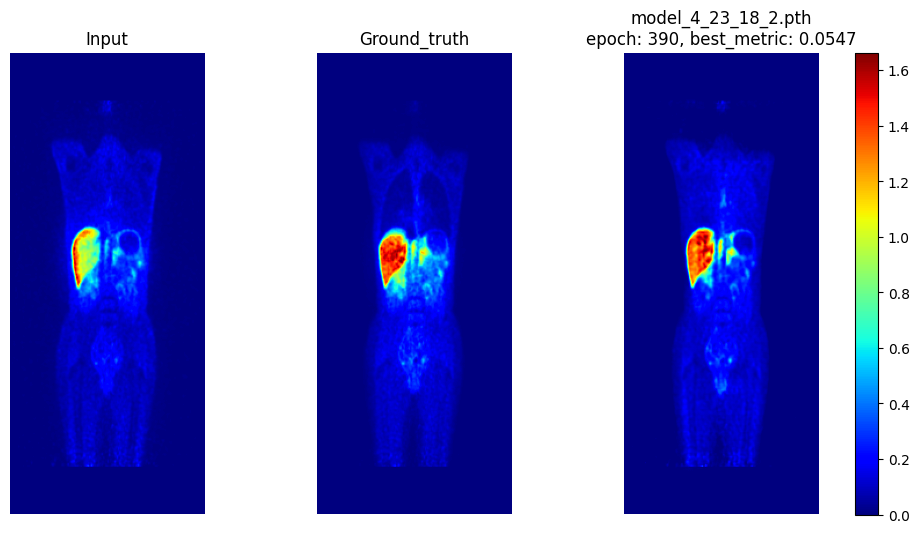

100%|██████████| 3/3 [01:59<00:00, 39.74s/it]


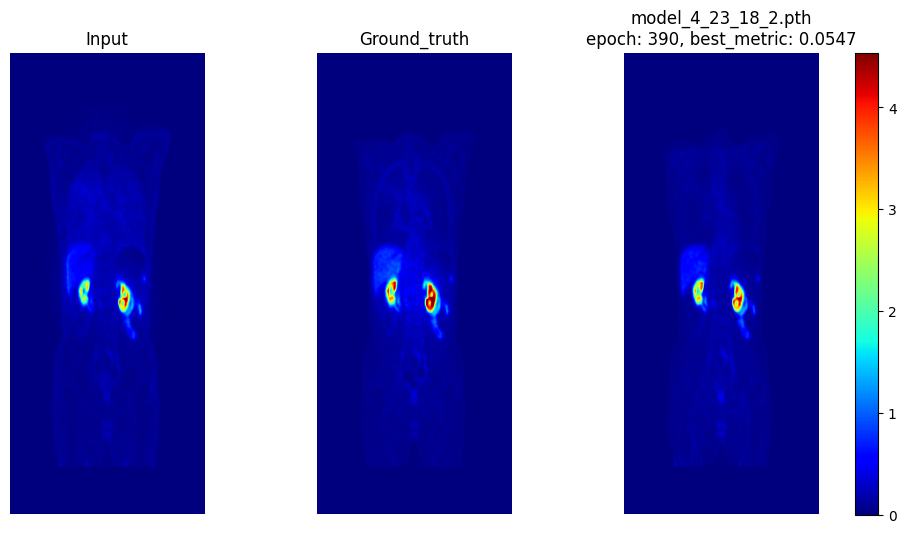

100%|██████████| 3/3 [01:36<00:00, 32.03s/it]


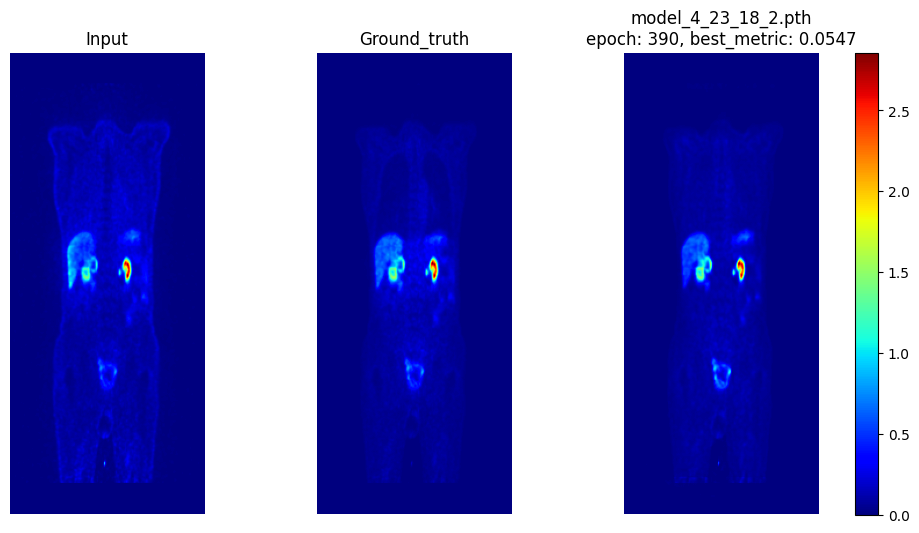

In [18]:
import torch
from data_preparation import visualize_coronal_slice

roi_size = (160, 160, 32)
sw_batch_size = 64
slice_number = 95

with torch.no_grad():
    for i, data in enumerate(test_loader):

        predict = sliding_window_inference(data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70)
        
        visualize_coronal_slice(data, predict, slice_number, 
                                f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}", 
                                "jet", Norm=False)
        if i == 2:
            break


In [22]:

from monai.transforms import Compose
from data_preparation import ClampNegative


roi_size = (160, 160, 32)
sw_batch_size = 64


post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=loader_factory.get_test_transforms(),
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        ClampNegative(keys=["pred"]),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=ga_output_dir, output_postfix="dl4_23", resample=False), 
    ]
)
# comb_3_27_onfdg_v2 fdg_output_dir
# 


with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.70)
        post_processed = [post_transforms(i) for i in decollate_batch(test_data)]



No negative values in pred
2024-04-30 19:07:35,230 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/GA_OUTPUT/007026_C5_RJ_/007026_C5_RJ__dl4_23.nii.gz
No negative values in pred
2024-04-30 19:10:03,317 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/GA_OUTPUT/007035_C5_RJ_/007035_C5_RJ__dl4_23.nii.gz
No negative values in pred
2024-04-30 19:12:30,447 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/GA_OUTPUT/007037_C5_RJ_/007037_C5_RJ__dl4_23.nii.gz
No negative values in pred
2024-04-30 19:14:25,893 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/GA_OUTPUT/007038_C5_RJ_/007038_C5_RJ__dl4_23.nii.gz
No negative values in pred
2024-04-30 19:16:53,661 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpouri/GA_OUTPUT/007042_C5_RJ_/007042_C5_RJ__dl4_23.nii.gz
No negative values in pred
2024-04-30 19:18:49,780 INFO image_writer.py:197 - writing: /students/2023-2024/master/Shahpo

In [ ]:
# import os
# import glob
# from utils import PairFinder
# hint = 'dl_dyn2'
# hint = 'gamodel_3_18_onfdg'
# hint = 'Areset_test'

# pair_finder = PairFinder(f'{fdg_data_dir}/MAC', output_dir, hint)
# test_dict_list = pair_finder.find_file_pairs()
# test_dict_list

In [ ]:
# import nibabel as nib
# import os

# for item in test_dict_list:
#     predicted_image_path = item['predicted']
#     reference_image_path = item['reference']
    
#     # Handle the '.nii.gz' extension properly
#     if predicted_image_path.endswith('.nii.gz'):
#         base_path = predicted_image_path[:-7]  # Remove '.nii.gz' from the end
#         corrected_dl_image_path = f"{base_path}_corr.nii.gz"
#     else:
#         # For other extensions, split and append '_corrected' before the extension
#         base_path, ext = os.path.splitext(predicted_image_path)
#         corrected_dl_image_path = f"{base_path}_corr{ext}"
    
#     # Load the reference (original) image to get its affine and header
#     orig = nib.load(reference_image_path)
    
#     # Load the DL predicted image
#     dl = nib.load(predicted_image_path)
#     dl_data = dl.get_fdata()
    
#     # Create a new NIfTI image using the DL data but with the original affine and header
#     corrected_dl_img = nib.Nifti1Image(dl_data, orig.affine, header=orig.header.copy())
    
#     # Save the corrected DL image
#     nib.save(corrected_dl_img, corrected_dl_image_path)
 
#     print(f"Corrected image saved to: {corrected_dl_image_path}")


In [ ]:
# # Second method:
# import numpy as np
# import nibabel as nib
# import os

# def write_nifti(data, file_name, affine, output_dtype=np.float32):
#     """
#     Writes the given NIfTI data to a file.

#     Parameters:
#     - data: The image data to write.
#     - file_name: The path to the file where the data should be saved.
#     - affine: The affine matrix for the NIfTI image.
#     - output_dtype: The desired data type for the saved image.
#     """
#     img = nib.Nifti1Image(data.astype(output_dtype), affine)
#     img.to_filename(file_name)

# # Assuming test_dict_list is defined as shown in your example
# for item in test_dict_list:
#     predicted_image_path = item['predicted']
#     reference_image_path = item['reference']
    
#     if predicted_image_path.endswith('.nii.gz'):
#         base_path = predicted_image_path[:-7]  # Correctly handles '.nii.gz' extension
#         corrected_dl_image_path = f"{base_path}_corr2.nii.gz"
#     else:
#         base_path, ext = os.path.splitext(predicted_image_path)
#         corrected_dl_image_path = f"{base_path}_corr2{ext}"
    
#     orig = nib.load(reference_image_path)
#     dl = nib.load(predicted_image_path)
#     dl_data = np.asanyarray(dl.dataobj)  # Directly accessing data
    
#     # Using write_nifti to save the corrected DL image
#     write_nifti(dl_data, corrected_dl_image_path, orig.affine, np.float32)
    
#     print(f"Corrected image saved to: {corrected_dl_image_path}")


In [ ]:
# import nibabel as nib
# import numpy as np

# original_image_path = '/students/2023-2024/master/Shahpouri/DATA/FDG_TEST/MAC/006051_dataset_07_A.nii.gz'
# dl_image_path = '/students/2023-2024/master/Shahpouri/OUTPUT/006051_dataset_07_A/006051_dataset_07_A_test.nii.gz'
# corrected_dl_image_path = '/students/2023-2024/master/Shahpouri/OUTPUT/006051_dataset_07_A/006051_dataset_07_A_corrected.nii.gz'

# # Load the original image to get its affine and header
# orig = nib.load(original_image_path)

# # Load the DL predicted image
# dl = nib.load(dl_image_path)
# # Extract the data from the DL predicted image
# dl_data = dl.get_fdata()

# # Create a new NIfTI image using the DL data but with the original affine and header
# corrected_dl_img = nib.Nifti1Image(dl_data, orig.affine, header=orig.header.copy())

# # Save the DL image with the updated header to the corrected path
# nib.save(corrected_dl_img, corrected_dl_image_path)

# # Load the newly saved corrected DL image
# dl_new = nib.load(corrected_dl_image_path)

# # Print the affine matrix for verification
# print("Affine matrix for original image:", orig.affine)
# print("Affine matrix for dl image:", dl.affine)
# print("Affine matrix for corrected dl image:", dl_new.affine)
